Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


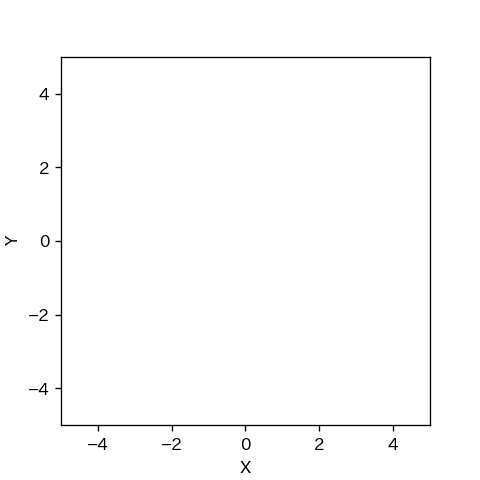

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


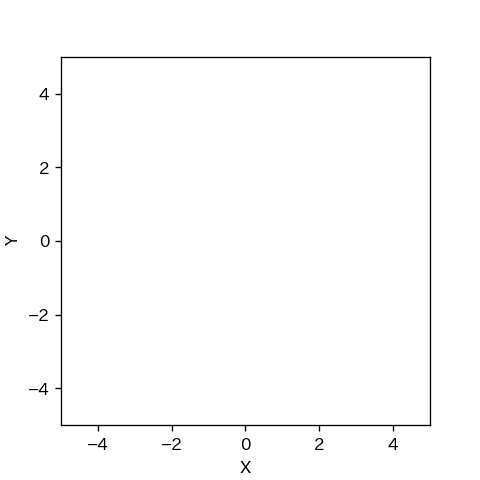

(array([ 4.89310272,  0.50989404, -1.04455697]),
 array([0.77596448, 1.59679256, 0.75096179]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[6.30099877196996]
0 真値: [ 4.50201627 -0.84222519  4.0664029 ] 推定値: [ 4.03189756 -1.20936519  4.1422568 ] 誤差: 0.5964925628341271
1
[3.354451047563816]
1 真値: [-3.70619618  6.63489747  3.61710341] 推定値: [-7.40091054  3.3737961   4.84484001] 誤差: 4.928051984823234
[6.660464029194275]
2 真値: [-2.04100438  0.3025592   3.28891432] 推定値: [-1.809563   -0.07731695  3.28079514] 誤差: 0.4448269391980083
2
[4.80488212558344]
3 真値: [-2.83438084  5.36033099  5.50574592] 推定値: [-2.76271268  5.31293298  5.38037603] 誤差: 0.08592378338748952
3
[1.5102610721032745]
4 真値: [-4.57828957  0.56023138  5.66054307] 推定値: [-5.28538051  3.0432521   3.48843336] 誤差: 2.581737686359738
[7.099031769442438]
5 真値: [-1.7895535   0.4366167   1.55969258] 推定値: [-2.05335945  0.3531698   1.4596614 ] 誤差: 0.2766892855579484
4
[4.33220274732837]
[3.268803880121572]
6 真値: [2.63000712 2.84987156 2.94407571] 推定値: [ 3.39978715  3.27581717 -0.54175857] 誤差: 0.8797675634901051
5
[1.8160963186181132]
7 真値: [ 0.54554658 -2.26210964  9.28100816] 推

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[2.292953583756743]
20 真値: [-0.43310556  2.10242462  8.45370817] 推定値: [-0.06523946  2.35518614  2.16842241] 誤差: 0.4463337949523068
14
[2.641140084053974]
21 真値: [-0.4130523   1.99701196  5.61949661] 推定値: [-0.07414605  2.41334141  5.4540986 ] 誤差: 0.5368311288400333
15
[4.395279033952571]
[3.7362921282323547]
22 真値: [ 0.64807644 -0.59828737  8.26386176] 推定値: [ 1.11879475 -0.4456882   2.09688991] 誤差: 0.4948355615595696
16
[4.973751951243514]
23 真値: [0.96295196 4.66354728 6.05291177] 推定値: [7.84530435e-01 3.91532656e+00 3.21908679e-04] 誤差: 0.7691999071693124
17
[2.4368105596246896]
[5.528275351264168]
24 真値: [3.31074773 2.33308139 4.34294296] 推定値: [-2.42295048 -0.60376192 -0.62535406] 誤差: 6.442076043661114
25 真値: [2.41530267 1.67226978 3.97095939] 推定値: [2.62493388 1.65120703 3.88617917] 誤差: 0.2106866919479561
18
[6.6520664892025705]
26 真値: [1.62179225 2.96470507 4.55405898] 推定値: [-2.8038863   9.02967745 -0.68935551] 誤差: 7.508030402318437
[6.7141448862500495]
27 真値: [-2.24395232 -2.94332125 